In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
!mkdir -p source

In [3]:
import pandas as pd
import altair as alt
import boto3
sm = boto3.client('sagemaker')
alt.renderers.enable('png')

RendererRegistry.enable('png')

In [4]:
%%writefile source/requirements.txt
transformers
accelerate
datasets
evaluate
peft

pynvml

Overwriting source/requirements.txt


In [5]:
%%writefile source/train.py
import sys
import os
import time
from threading import Thread
import logging
import argparse

import torch
import numpy as np

import datasets
import evaluate
import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)
import peft
from peft import (
    get_peft_model,
    LoraConfig,
    TaskType
)

logger = logging.getLogger(__name__)
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger.setLevel(logging.DEBUG)

logger.info(f'transformers {transformers.__version__}')
logger.info(f'peft {peft.__version__}')
logger.info(f'torch {torch.__version__}')

def count_parameters(m, verbose=True):
    total_count = 0
    learnable_count = 0
    if verbose:
        logger.debug("Parameters (name, tunable, count):")

    output_width = max([len(n) for n, _ in m.named_parameters()])
    for n, p in m.named_parameters():
        count = p.data.numel()
        if verbose:
            logger.debug(f" {n:{output_width}} {p.requires_grad:5b} {count:>11d}")
        total_count += count
        if p.requires_grad:
            learnable_count += count

    logger.info(
        f"Total parameters: {total_count:,}, "
        f"thereof learnable: {learnable_count:,} "
        f"({learnable_count/total_count*100.:5.4f}%)"
    )

    return total_count, learnable_count

def compute_metrics(eval_pred):
    load_accuracy = evaluate.load("accuracy")
 
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = load_accuracy.compute(predictions=predictions, references=labels)[
        "accuracy"
    ]
 
    metrics = {f"accuracy": accuracy}
 
    return metrics

def fit(args):
    ### model / tokenizer
    model = AutoModelForSequenceClassification.from_pretrained(args.hf_ckp, num_labels=2)
    tokenizer = AutoTokenizer.from_pretrained(args.hf_ckp)
    collator = DataCollatorWithPadding(tokenizer=tokenizer)

    use_lora = True if args.use_hf_lora else False
    if args.use_hf_lora:
        peft_config = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            r=1
        )
        model = get_peft_model(model, peft_config)

    count_parameters(model, verbose=args.use_hf_lora)

    ### data 
    datasets.logging.disable_progress_bar()
    dataset = datasets.load_dataset("glue", "sst2")
    train = dataset["train"]
    valid = dataset["validation"]

    def preprocess_function(examples):
        return tokenizer(args.input_scale*examples['sentence'], padding=False, truncation=True)

    tokenized_train = train.map(preprocess_function, batched=False)
    tokenized_valid = valid.map(preprocess_function, batched=False)

    mean_length = np.mean([len(v['input_ids']) for v in tokenized_train])
    logger.info(f'Average train input length: {mean_length:5.2f}')

    ### Trainer
    
    log_steps = len(tokenized_train) // args.batch_size // 2 # 2 log outputs per epoch
    use_bf16 = True if args.use_bf16 and torch.cuda.is_available() else False
    print(f'Using bf16: {use_bf16}, LoRA: {use_lora}')
    
    training_args = TrainingArguments(
        output_dir=args.model_dir if args.model_dir else "out",    
        learning_rate=args.learning_rate,
        per_device_train_batch_size=args.batch_size,
        per_device_eval_batch_size=args.batch_size,
        num_train_epochs=5,
        weight_decay=0.1,
        push_to_hub=False,
        bf16=use_bf16,
        save_steps=log_steps,
        logging_steps=log_steps,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,
        disable_tqdm=True,
        metric_for_best_model='eval_accuracy',
        load_best_model_at_end=True
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_valid,
        tokenizer=tokenizer,
        data_collator=collator,
        compute_metrics=compute_metrics,
        # no early stopping for simplicity
    )

    ### train
    trainer.train()
    trainer.evaluate()
    

if __name__ == "__main__":

    def schedule_gpu_memory_logging():
        def log_gpu_usage():
            if not torch.cuda.is_available():
                return

            from pynvml.smi import nvidia_smi

            nvsmi = nvidia_smi.getInstance()
            res = nvsmi.DeviceQuery("memory.free, memory.total, memory.used")["gpu"][0][
                "fb_memory_usage"
            ]
            res["percentage"] = res["used"] / res["total"] * 100
            logger.info(
                f'GPU Usage. Used: {res["used"]:5.3f} Total: {res["total"]:5.3f} ({res["percentage"]:3.1f}% used). Free: {res["free"]:5.3f}'
            )
        
        def log_loop():
            while True:
                log_gpu_usage()
                time.sleep(30)
    
        t = Thread(target=log_loop, daemon=True)
        t.start()

    schedule_gpu_memory_logging()

    parser = argparse.ArgumentParser()
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--use-bf16", type=int, default=1, help='1 yes, 0 no') 
    parser.add_argument("--use-hf-lora", type=int, default=0, help='1 yes, 0 no')
    parser.add_argument("--learning-rate", type=float, default=4e-5)
    parser.add_argument("--batch-size", type=int, default=224)
    parser.add_argument("--input-scale", type=int, default=1)
    parser.add_argument("--hf-ckp", type=str, default='roberta-base')

    args, _ = parser.parse_known_args()

    fit(args)


Overwriting source/train.py


In [6]:
# Run locally with:
#!python source/train.py --input-scale 1 --batch-size 16

In [7]:
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role

hyperparameters = {
    'use-bf16'  : 1,
    'use-hf-lora': 1,
    'learning-rate': 4e-5,
    'batch-size': 16, # 224
    'hf-ckp': 'roberta-base'
}

metric_definitions = [
    
    {'Name': 'train_samples_per_second', 'Regex': '\'train_samples_per_second\': (-?[0-9\\.]+)'},
    {'Name': 'valid_acc', 'Regex': '\'eval_accuracy\': (-?[0-9\\.]+)'},
    {'Name': 'gpu_mem', 'Regex': 'GPU Usage.*?(-?[0-9\\.]+)% used'}
]

estimator_parameters = dict(
    source_dir         = 'source',
    entry_point        = 'train.py',
    instance_type      = 'ml.g5.xlarge',
    instance_count     = 1,
    framework_version  = '2.0',
    py_version         = 'py310',
    use_spot_instances = True,
    max_run            = 24*60*60, # one day in seconds
    max_wait           = 24*60*60, 
    role               = get_execution_role(),
    metric_definitions = metric_definitions,
    hyperparameters    = hyperparameters
)

In [8]:
estimators = []
for type in ['lora', 'full']:
    for bits in [16, 32]:
        for input_scale in [1, 8]:
            est = PyTorch(**estimator_parameters)
            est.set_hyperparameters(**{'use-bf16':      1    if bits == 16 else 0})
            est.set_hyperparameters(**{'use-hf-lora':   1    if type == 'lora' else 0})
            est.set_hyperparameters(**{'learning-rate': 4e-4 if type == 'lora' else 5e-5})
            est.set_hyperparameters(**{'input-scale': input_scale})
            est.fit(wait=False)
            estimators.append((type, bits, est, input_scale))

Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-09-18-15-23-54-927
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-09-18-15-23-56-404
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-09-18-15-23-58-943
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-09-18-15-24-00-434
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-09-18-15-24-01-863
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-09-18-15-24-03-176
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-09-18-15-24-04-500
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-09-18-15-24-05-911


In [9]:
def get_job_metrics(estimator, metric_names=None):
    if isinstance(metric_names, str):
        metrics = [metric_names]
        
    final_metrics = sm.describe_training_job(
        TrainingJobName=estimator.latest_training_job.job_name)['FinalMetricDataList']
    return {fm['MetricName']: fm['Value'] for fm in final_metrics if metric_names is None or (fm['MetricName'] in metric_names)}

In [10]:
results = []
# capture data
for type, bits, est, input_scale in estimators:
    job_name = est.latest_training_job.job_name
    sm.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
    metrics = get_job_metrics(est, ['valid_acc', 'gpu_mem', 'train_samples_per_second'])
    results.append(
        (type, 
         bits,
         input_scale,
         metrics['valid_acc'], 
         metrics['gpu_mem'],
         metrics['train_samples_per_second'])
    )
results_df = pd.DataFrame(data=results, columns=['type', 'bits', 'input_scale', 'accuracy', 'gpu_memory', 'train_samples_per_second']); results_df

,type,bits,input_scale,accuracy,gpu_memory,train_samples_per_second
0,lora,16,1,0.936927,7.600000,382.018005
1,lora,16,8,0.932339,35.000000,136.339996
2,lora,32,1,0.934633,7.800000,449.243988
3,lora,32,8,0.931193,43.000000,91.526001
4,full,16,1,0.918578,16.900000,267.427002
5,full,16,8,0.910550,45.799999,111.926003
6,full,32,1,0.916284,16.799999,262.984009
7,full,32,8,0.917431,79.800003,72.971001


In [13]:
results_df.to_markdown()

'|    | type   |   bits |   input_scale |   accuracy |   gpu_memory |   train_samples_per_second |\n|---:|:-------|-------:|--------------:|-----------:|-------------:|---------------------------:|\n|  0 | lora   |     16 |             1 |   0.936927 |          7.6 |                    382.018 |\n|  1 | lora   |     16 |             8 |   0.932339 |         35   |                    136.34  |\n|  2 | lora   |     32 |             1 |   0.934633 |          7.8 |                    449.244 |\n|  3 | lora   |     32 |             8 |   0.931193 |         43   |                     91.526 |\n|  4 | full   |     16 |             1 |   0.918578 |         16.9 |                    267.427 |\n|  5 | full   |     16 |             8 |   0.91055  |         45.8 |                    111.926 |\n|  6 | full   |     32 |             1 |   0.916284 |         16.8 |                    262.984 |\n|  7 | full   |     32 |             8 |   0.917431 |         79.8 |                     72.971 |'

'---- GPU Memory ----'

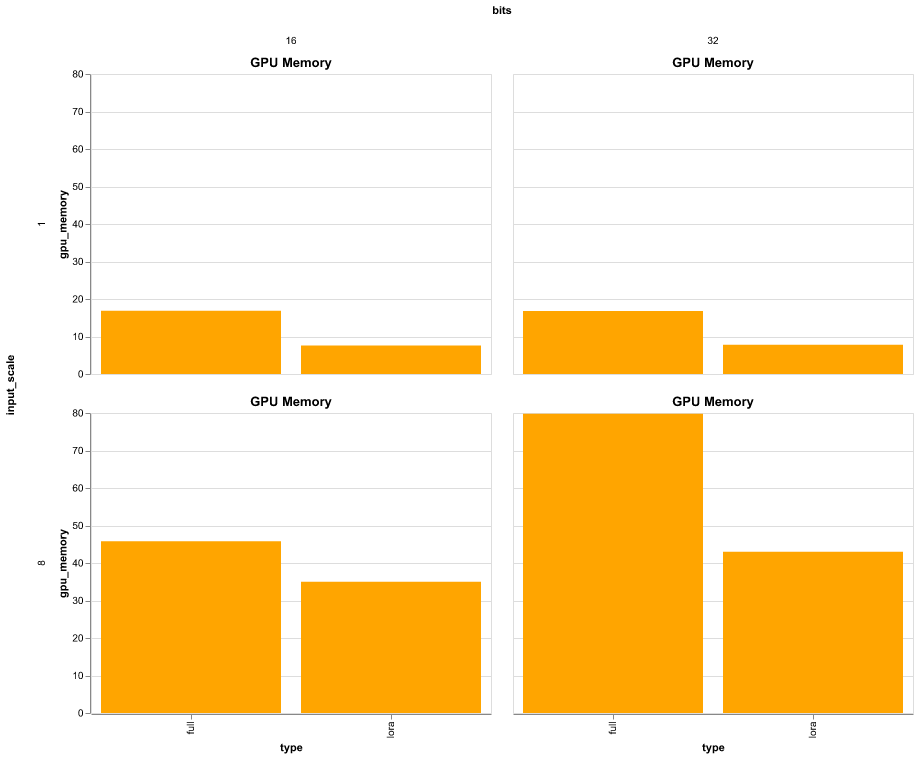

'---- Model Performance ----'

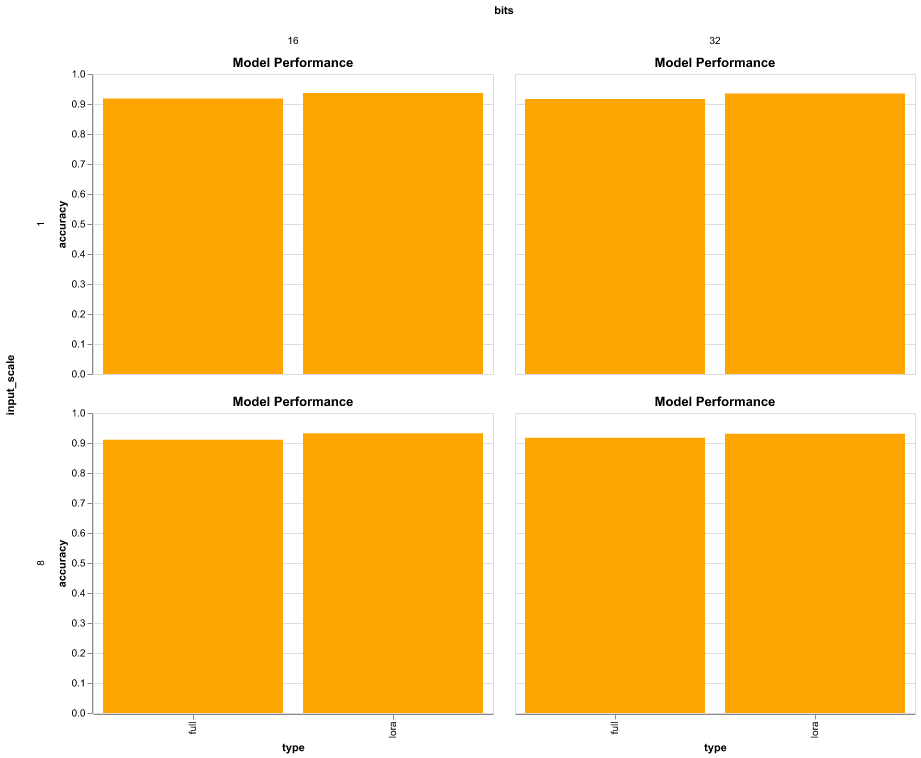

'---- Training Speed ----'

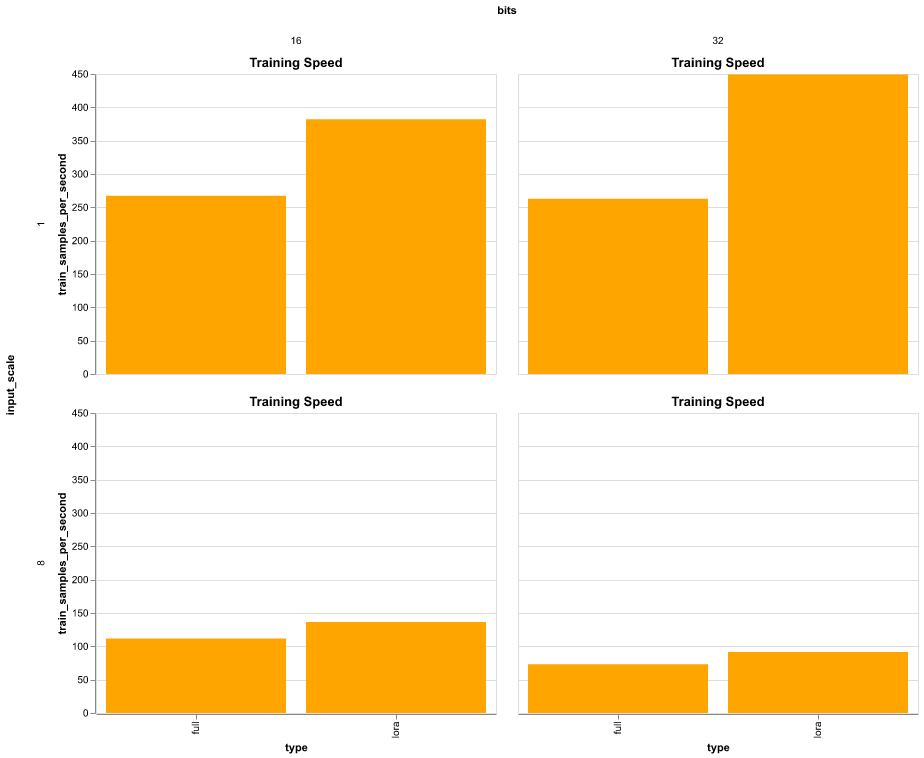

In [16]:
for title, field in [
    ('GPU Memory', 'gpu_memory'),
    ('Model Performance', 'accuracy'),
    ('Training Speed', 'train_samples_per_second'),
]:
    display(f'---- {title} ----')
    display(alt.Chart(results_df, title=title, width=400).mark_bar(color='orange').encode(
        x='type:N',
        y=alt.Y(f'{field}:Q').scale(zero=False),
    ).facet(column='bits:O', row='input_scale:O'))

In [ ]:
# All experiments use the same batch-size
# All experiments ran on their own machines/GPUs

## Full Logs

In [15]:
for type, bits, est, input_scale in estimators:
    job_name = est.latest_training_job.job_name
    sm.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
    print(f'\n\n\n##### Log of {job_name} ({type}, {bits}):\n')
    est.logs()




##### Log of pytorch-training-2023-09-18-15-23-54-927 (lora, 16):

2023-09-18 15:46:09 Starting - Preparing the instances for training
2023-09-18 15:46:09 Downloading - Downloading input data
2023-09-18 15:46:09 Training - Training image download completed. Training in progress.
2023-09-18 15:46:09 Uploading - Uploading generated training model
2023-09-18 15:46:09 Completed - Training job completedbash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-09-18 15:30:28,843 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-09-18 15:30:28,857 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-09-18 15:30:28,865 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-09-18 15:30:28,872 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-09-18 15:30:30,625 sagemaker-training